In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
import itertools
from tqdm.notebook import tqdm
from glob import glob
from scipy.stats import norm
from scipy.special import softmax
from datetime import datetime, time

from model import baseline
from model.helpers import square_exponential_kernel, normalize_last_dim
from plot import plot
from data.data_path import data_path

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

# from model.ball_base_model import *
from scripts.compute_transition_matrices import plot_transition_matrix

In [3]:
def load_data(u):

    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]

    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format="ISO8601")
    df.dt = df.dt.dt.tz_convert("Europe/London")

    all_pos = df.step_midnight.values

    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestamp = (
        np.asarray(
            [
                (dt - datetime.combine(dt, time.min, dt.tz)).total_seconds()
                for dt in df.dt
            ]
        )
        / 86400
    )  # in fraction of day (between 0 and 1)

    # List of step events for each day, the event itself being the timestamp of the step
    step_events = [[] for _ in range(uniq_days.size)]

    for idx_day, day in enumerate(uniq_days):
        is_day = days == day
        obs_timestamp, obs_pos = all_timestamp[is_day], all_pos[is_day]

        # Sort the data by timestamp
        idx = np.argsort(obs_timestamp)
        obs_timestamp, obs_pos = obs_timestamp[idx], obs_pos[idx]

        # Compute the number of steps between each observed timestamp
        diff_obs_pos = np.diff(obs_pos)

        for ts, dif in zip(obs_timestamp, diff_obs_pos):
            # TODO: In the future, we probably want to spread that
            #  over a period assuming something like 6000 steps per hour
            step_events[idx_day] += [ts for _ in range(dif)]

    return step_events

In [4]:
user = "11AV"  # Select the user to use
bkp_folder = f"../../bkp/compute_transition_matrices/{user}*"

# jitter = np.finfo(np.float64).tiny

In [5]:
# ------------------------------------------------------------------------
# Compute cumulative step number and its derivative
# ------------------------------------------------------------------------

# Define the number of timesteps
n_timestep = 9

# Load data
step_events = load_data(user)

n_days = len(step_events)

timestep = np.linspace(0, 1, n_timestep+1)
X_train = []
y_train = []
deriv_cum_steps = np.zeros((n_days, timestep.size))
for idx_day in range(n_days):
    cum_steps_day = np.sum(step_events[idx_day] <= timestep[:, None], axis=1)
    deriv_cum_steps_day =  np.gradient(cum_steps_day, timestep+1) / timestep.size
    deriv_cum_steps[idx_day] = deriv_cum_steps_day
    
    X_train.append(list(timestep))
    y_train.append(list(deriv_cum_steps_day))

    # X_train.append(x)
    # y_train.append(np.log(y))
    
sum_steps = np.sum(deriv_cum_steps, axis=1)
print(f"{np.max(sum_steps):.02f} +/= {np.std(sum_steps):.02f}")


7493.40 +/= 2458.43


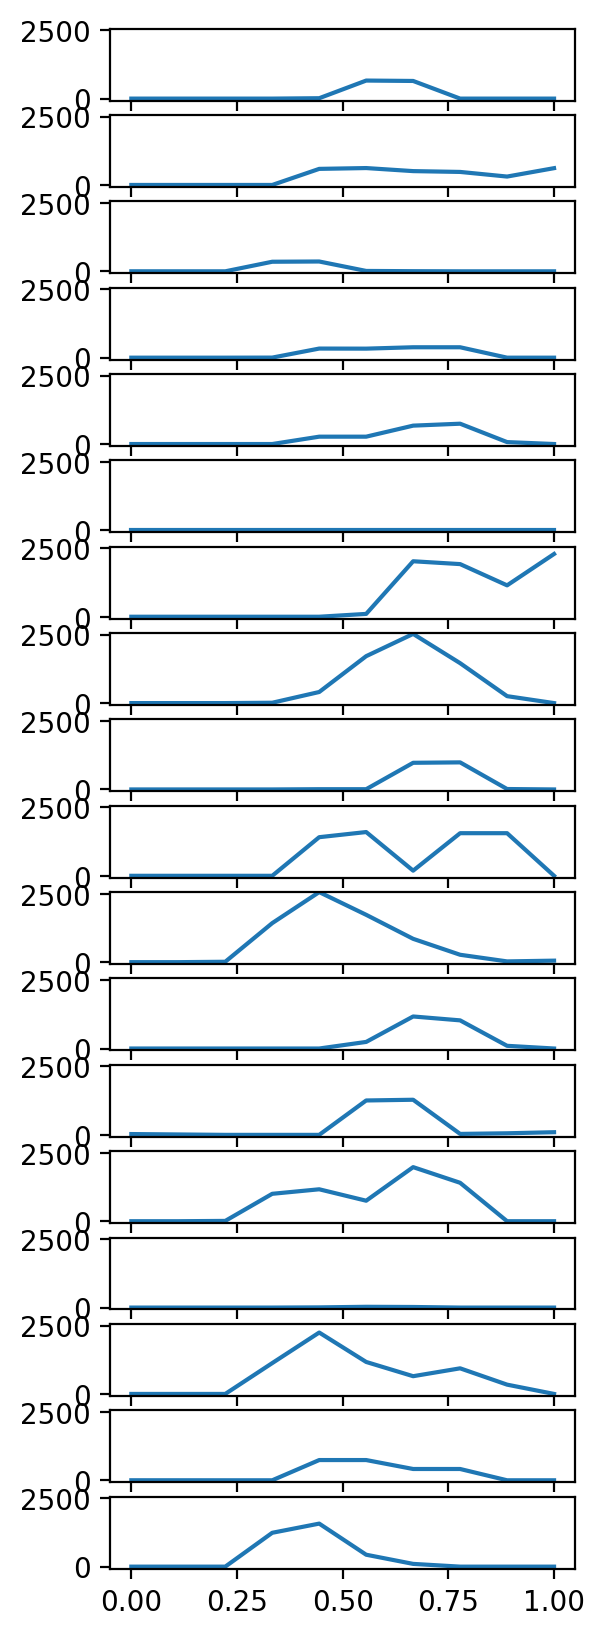

In [6]:
fig, axes = plt.subplots(deriv_cum_steps.shape[0], figsize=(3, 10), sharex=True)
for ax, activity in zip(axes, deriv_cum_steps):
    ax.plot(timestep, activity, color="C0")
    ax.set_ylim(-70, np.max(deriv_cum_steps))
    ax.grid(False)

In [7]:
deriv_cum_steps 

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         1.4400000e+01,  6.5925000e+02,  6.4485000e+02,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         5.8770000e+02,  6.1740000e+02,  5.0580000e+02,  4.7610000e+02,
         3.0690000e+02,  6.1380000e+02],
       [ 9.0000000e-01,  4.5000000e-01,  8.8817842e-17,  3.4965000e+02,
         3.5865000e+02,  1.3500000e+01,  4.5000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  2.7000000e+00,
         3.3255000e+02,  3.2985000e+02,  3.8025000e+02,  3.8025000e+02,
         0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         2.6865000e+02,  2.6865000e+02,  6.7185000e+02,  7.4250000e+02,
         7.0650000e+01,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
   

In [8]:
# Normalize the data
X_train = np.asarray(X_train)#.reshape(-1, 1)
y_train = np.asarray(y_train)
x_scaler, y_scaler = StandardScaler(), StandardScaler()
X_train = x_scaler.fit_transform(X_train)
y_train = y_scaler.fit_transform(y_train)
# X_test = scaler.transform(X_test)
# X_to_predict = scaler.transform(X_to_predict)

In [9]:
#fig, ax = plt.subplots(figsize=(5, 2))
#ax.scatter(X_train.flatten(), y_train, color="C0", alpha=0.5, s=10)

In [10]:
kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-10, 1e4)) * RBF(length_scale=1.0, length_scale_bounds=(1e-10, 1e4)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-4, 1e4))
# Add Matern Kernel
# kernel = Matern(length_scale=2, length_scale_bounds=(1e-10, 1e10), nu=1.5)

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gp.fit(X_train, y_train)
print(gp.kernel_)

1.39e-05**2 * RBF(length_scale=3.66e-05) + WhiteKernel(noise_level=1)


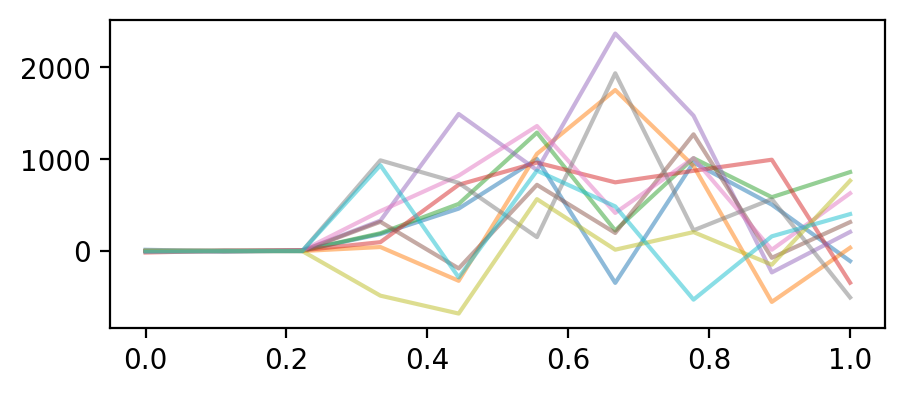

In [11]:
# Define the points where we want to sample from the posterior
# X = np.linspace(0, 5, 100).reshape(-1, 1)
X_ = timestep.reshape(1, -1)
X = x_scaler.transform(X_)

# Draw samples from the posterior at the given points
y_samples = gp.sample_y(X, n_samples=10, random_state=11)

fig, ax = plt.subplots(figsize=(5, 2))

# Plot the samples
for idx, sample in enumerate(y_samples.T):
    x = X_.flatten()
    y = y_scaler.inverse_transform(sample.reshape(1, -1)).flatten()
    ax.plot(x, y, alpha=0.5, color=f"C{idx}")
    #ax.set_ylim(0, 30000)
plt.show()

ValueError: x has 3 columns but y has 2 columns

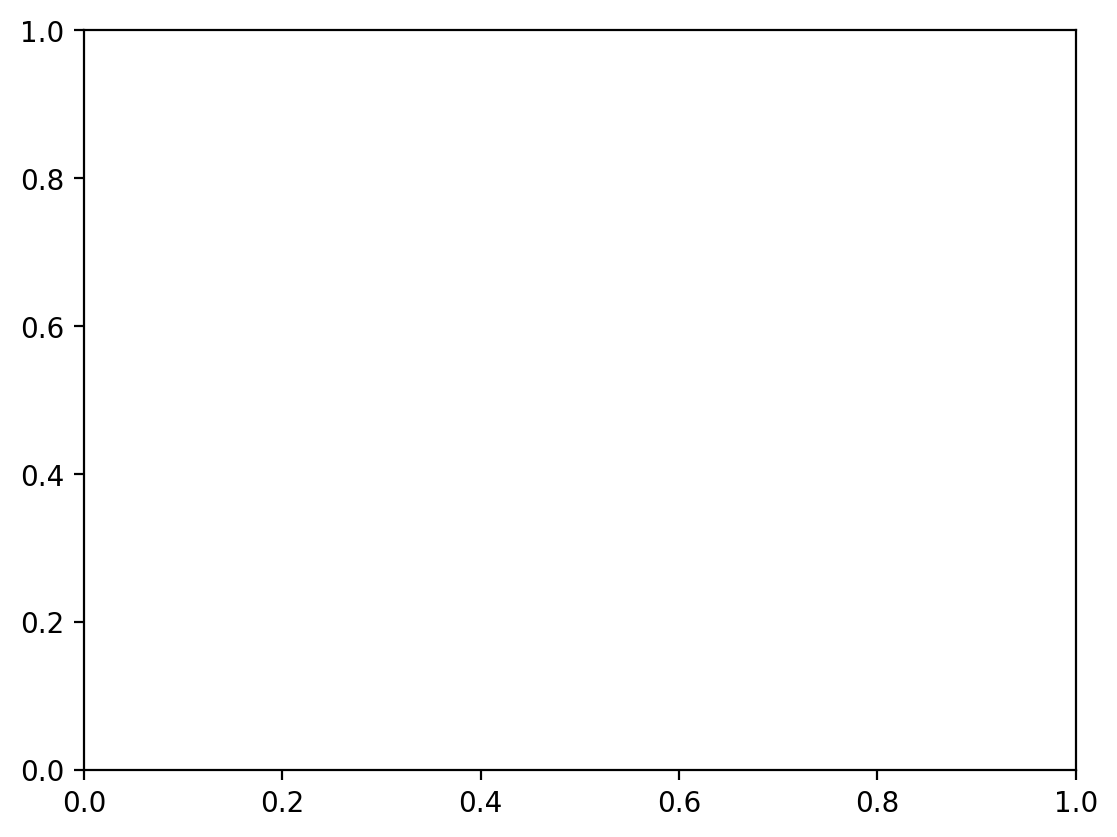

In [14]:
y_pred, sigma = gp.predict(X, return_std=True)

# Plot the function, the prediction and the 95% confidence interval
plt.figure()
plt.plot(X, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([X, X[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
# plt.scatter(X, y, c='r', label='Observations')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
# plt.legend(loc='upper left')

In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np

# Assume X is your feature matrix and y is your target matrix
X = np.random.rand(100, 3)  # 100 samples, 3 input features each
y = np.random.rand(100, 2)  # 100 samples, 2 output features each

# Kernel for the GP
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Create a GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1)

# Fit to data
gp.fit(X, y)

# Predict
X_test = np.random.rand(10, 3)  # 10 test samples
y_pred = gp.predict(X_test)

print(y_pred)  # predicted values for the 2 output features

[[0.49926979 0.47811132]
 [0.49934438 0.47812019]
 [0.4990392  0.47805705]
 [0.49914671 0.47806944]
 [0.4994161  0.47808234]
 [0.49934467 0.4781129 ]
 [0.49909449 0.4780708 ]
 [0.49922115 0.47812593]
 [0.49907671 0.47807129]
 [0.49905456 0.47814093]]


/Users/aureliennioche/.pyenv/versions/3.9.13/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
